In [255]:
import pandas as pd
import time
import numpy as np


from scipy.stats import uniform, randint

#visualizing data
import seaborn as sns  
import matplotlib.pyplot as plt 

#model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Model Training
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV


#Evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score



In [180]:
df_customers  = pd.read_csv('data/ACME-HappinessSurvey2020.csv')

In [181]:
df_customers.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


- X1 = Order on Time
- X2 = Contents as Expected
- X3 = Ordered Everything I wanted to order
- X4 = I paid a good price for my order
- X5 = I am satisfied with my courier
- X6 = the app makes ordering easy for me


Goal: Predict Customer Happiness

In [182]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


In [183]:
df_customers.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [184]:
#tst

In [185]:
df_customers.describe().T

,count,mean,std,min,25%,50%,75%,max
Y,126.0,0.547619,0.499714,0.0,0.0,1.0,1.0,1.0
X1,126.0,4.333333,0.800000,1.0,4.0,5.0,5.0,5.0
X2,126.0,2.531746,1.114892,1.0,2.0,3.0,3.0,5.0
X3,126.0,3.309524,1.023440,1.0,3.0,3.0,4.0,5.0
X4,126.0,3.746032,0.875776,1.0,3.0,4.0,4.0,5.0
X5,126.0,3.650794,1.147641,1.0,3.0,4.0,4.0,5.0
X6,126.0,4.253968,0.809311,1.0,4.0,4.0,5.0,5.0


X1 (Order comes on time) and X6 (App makes it easy to order) have the highest means for the attributes. X2 (Contents as Expected) have the lowest.

<AxesSubplot: >

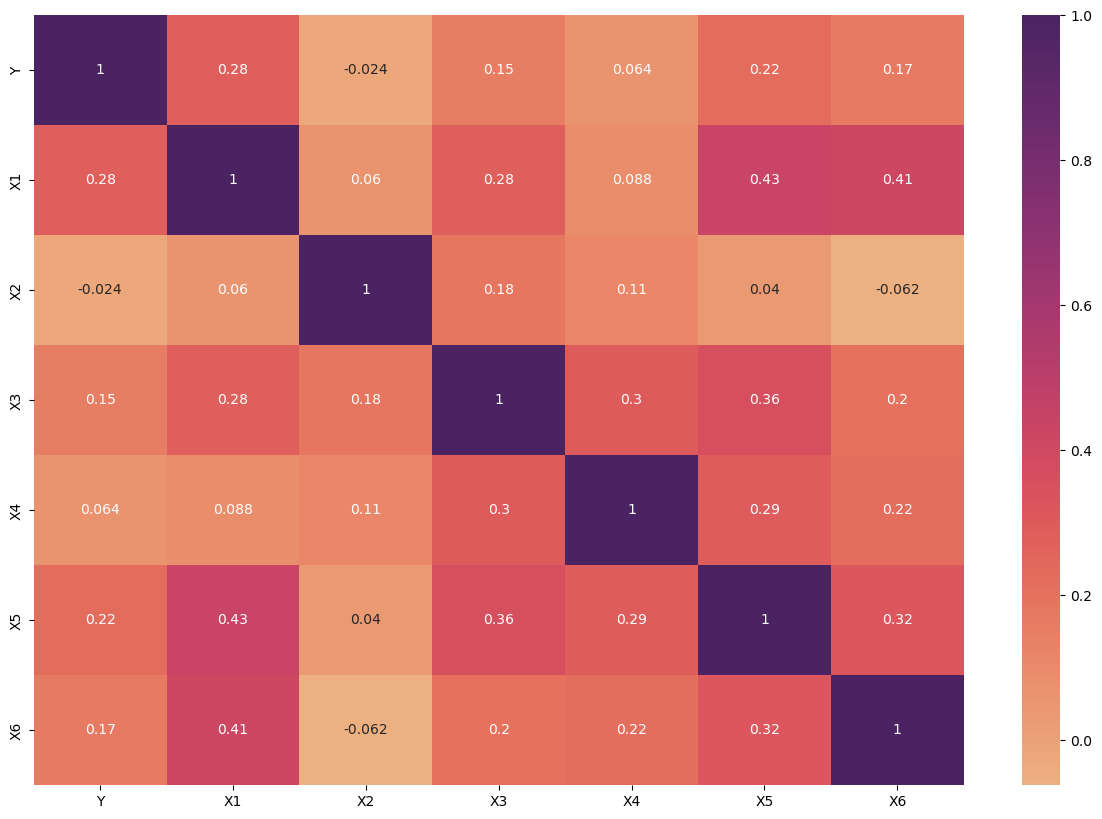

In [186]:
fig, ax = plt.subplots(figsize=(15,10))  
corr = df_customers.corr()
sns.heatmap(corr, annot=True, cmap="flare")

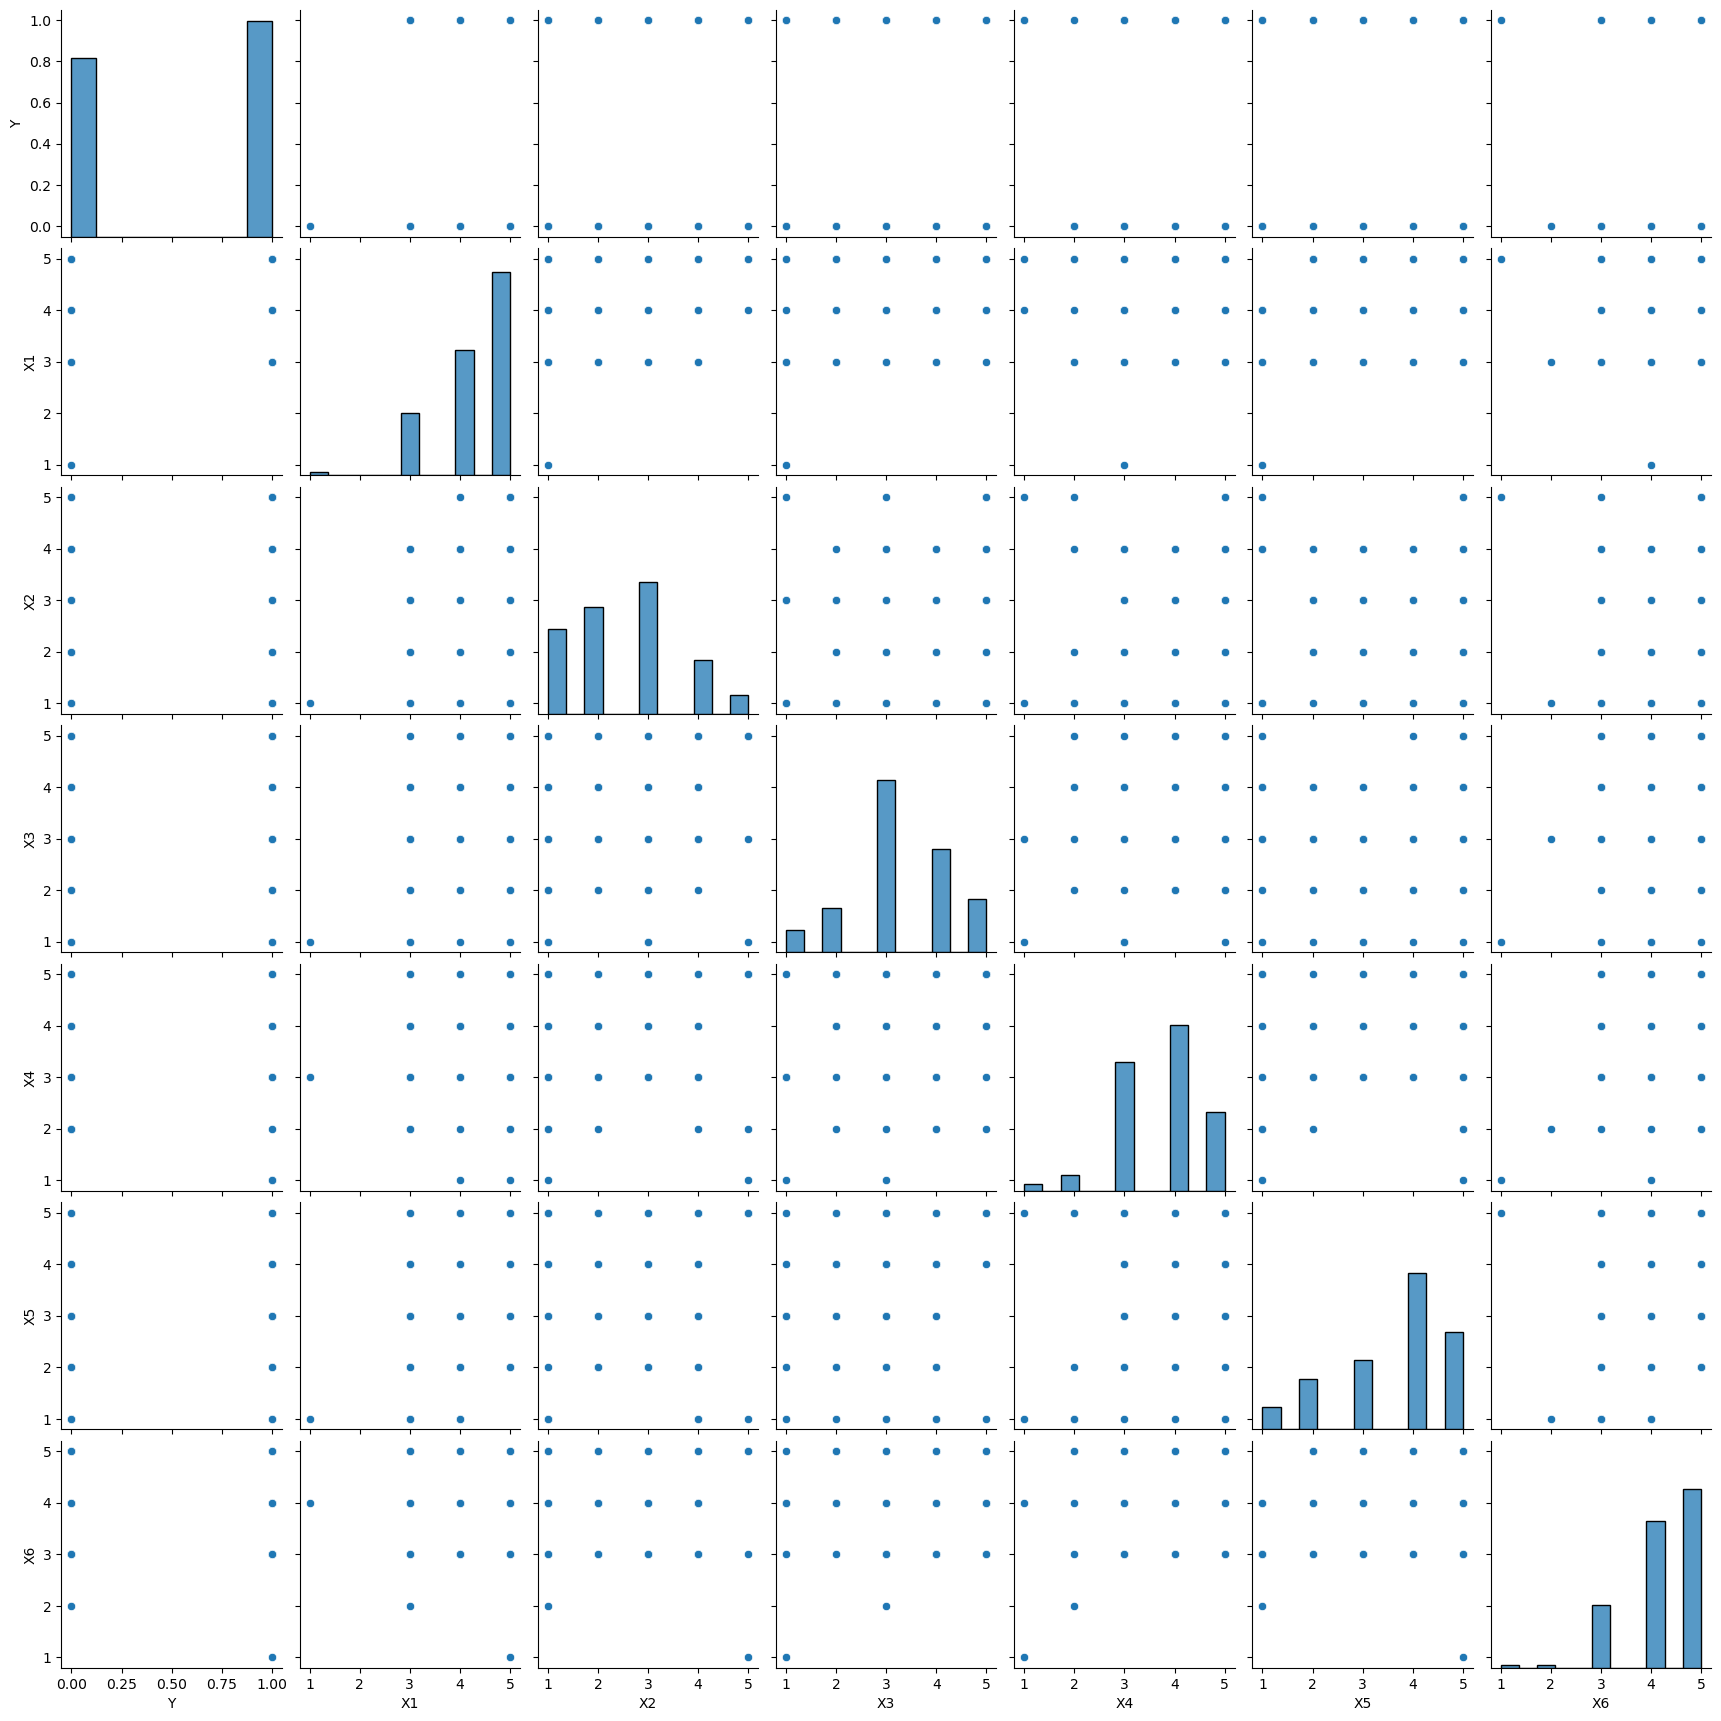

In [187]:
sns.pairplot(df_customers)

Check missing values

In [188]:
df_customers.isnull().sum()

Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64

# Feature Engineering

In [189]:
# df_customers['x1x6'] = df_customers['X1'] * df_customers['X6']
# df_customers['x1x5'] = df_customers['X1'] * df_customers['X5']

In [190]:
#separate the Target and Features
target = df_customers['Y'] 
features = df_customers.drop(['Y'], axis=1)

In [249]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state= 32) 

In [250]:
print(features.shape)
print(target.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)



(126, 6)
(126,)
(100, 6)
(26, 6)
(100,)
(26,)


In [251]:
print(y_train.value_counts())
print(y_test.value_counts())

1    54
0    46
Name: Y, dtype: int64
1    15
0    11
Name: Y, dtype: int64


The Training and Testing set seems balanced

# Model Development

In [194]:
import xgboost as xgb

In [195]:
def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20},cmap="Blues")

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

In [196]:
#simply print the best models and its parameters
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [197]:
def xgb_classifier(X_train, X_test, y_train, y_test, cv_folds = 5, early_stopping_rounds=50):


   params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
    }
#    param_test = {
#    "colsample_bytree": list(uniform(0.7, 0.3)),
#     "gamma": list(uniform(0, 0.5)),
#     "learning_rate": list(uniform(0.03, 0.3)), # default 0.1 
#     "max_depth": list(randint(2, 6)), # default 3
#     "n_estimators": list(randint(100, 150)), # default 100
#     "subsample": list(uniform(0.6, 0.4)),
#     'gamma':[i/10.0 for i in range(0,5)],
# }

   gsearch = RandomizedSearchCV(estimator = xgb.XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
   min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
   objective= 'binary:logistic', nthread=2,seed=27), 
   param_distributions= params, scoring='accuracy',n_jobs=4, cv=10)

    # alg = xgb.XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
    #                     min_child_weight=3, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
    #                     objective='binary:logistic', nthread=4, seed=32)

  

    # search = RandomizedSearchCV(alg, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

    
    # if use_cv:
    #     print('Start Feeding in the data:')
    #     xgb_params = alg.get_xgb_params()
    #     xgb_train = xgb.DMatrix(X_train.values,label=y_train.values)
    #     cv_result = xgb.cv(xgb_params,xgb_train,num_boost_round=alg.get_params()['n_estimators'],nfold=cv_folds,early_stopping_rounds=early_stopping_rounds)
    #     alg.set_params(n_estimators=cv_result.shape[0])

   print('Training start:')
   gsearch.fit(X_train,y_train)

   print("Start Predicting")
   predictions = gsearch.predict(X_test)
   pred_proba = gsearch.predict_proba(X_test)[:, 1]

   print(' Accuracy score: ', accuracy_score(y_test,predictions))

   conf_matrix(y_test,predictions)

   #feat_imp = gsearch.feature_importances_
   #feat = X_train.columns.tolist()
   # clf.best_estimator_.booster().get_fscore()
   #res_df = pd.DataFrame({'Features': feat, 'Importance': feat_imp}).sort_values(by='Importance', ascending=False)
   #res_df.plot('Features', 'Importance', kind='bar', title='Feature Importances')
   sorted_idx = gsearch.best_estimator_.feature_importances_.argsort()
   plt.figure(figsize=(10,10))
   plt.barh(X_train.columns[sorted_idx], gsearch.best_estimator_.feature_importances_[sorted_idx])
   plt.xlabel("Xgboost Feature Importance")
   plt.ylabel('Feature Importance Score')
   plt.show()
   #  print(res_df)
   #  print(res_df["Features"].tolist())

    


Training start:
Start Predicting
 Accuracy score:  0.2631578947368421


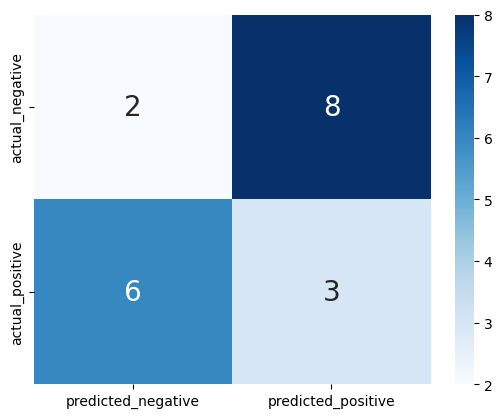

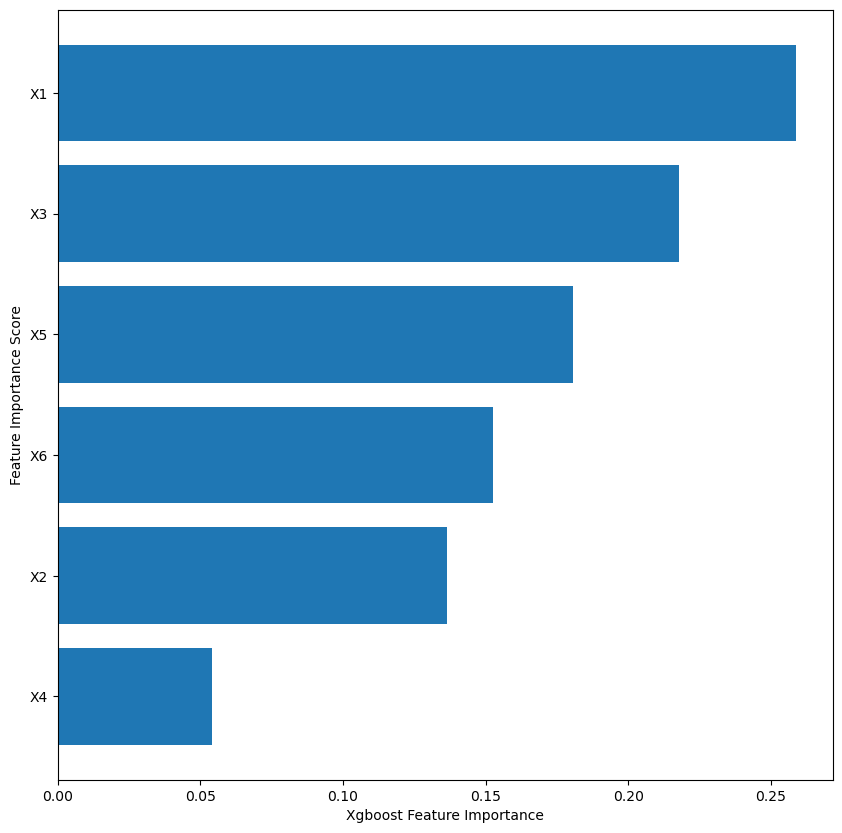

Total Time is:  0.049918635686238604


In [198]:
start = time.time()
xgb_classifier(X_train, X_test, y_train, y_test,)
print("Total Time is: ", (time.time() - start)/60)

In [199]:
logistic_reg = LogisticRegression(random_state=16)

In [200]:
logistic_reg.fit(X_train, y_train)

LogisticRegression(random_state=16)

In [201]:
y_pred = logistic_reg.predict(X_test)

[0.263, 0.273, 0.333, 0.3]

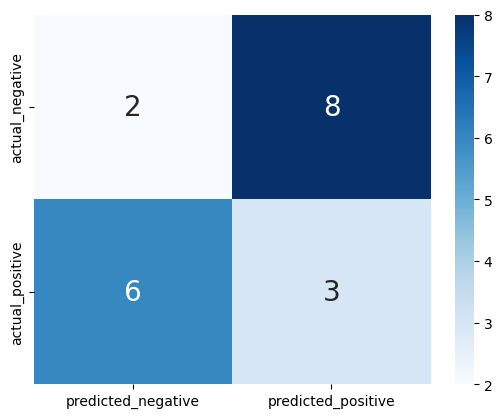

In [202]:
conf_matrix(y_test,y_pred)

In [203]:
print(' Accuracy score: ', accuracy_score(y_test,y_pred))

 Accuracy score:  0.2631578947368421


In [204]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6)

In [205]:
y_pred = knn.predict(X_test)

[0.263, 0.273, 0.333, 0.3]

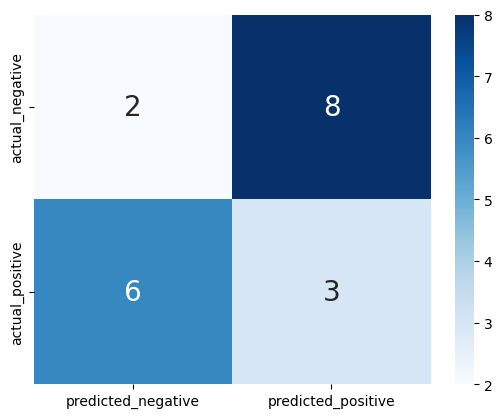

In [206]:
conf_matrix(y_test,y_pred)

In [207]:
print(' Accuracy score: ', accuracy_score(y_test,y_pred))

 Accuracy score:  0.2631578947368421


In [208]:
RFC = RandomForestClassifier(n_estimators=8)
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points
random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = RFC,param_distributions = random_grid,
               n_iter = 100, cv = 10, verbose=2, random_state=35, n_jobs = -1)

In [209]:
rf_random.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=5; total 

/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_

[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=70, ma

/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_

[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=110, 

/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_

[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max

/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_

[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=40, max

/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_

[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_

/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_

[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=90,

/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_

[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.0s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.0s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.0s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_f

/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_

[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=False, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.0s
[CV] END bootstrap=False, max_depth=110, max_features=a

/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_

[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=100, max_feat

/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_

[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=50, max_featu

/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=80, max_features

/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_

[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s

[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=100, ma

/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=110

/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_

[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END bootstrap=False, max_depth=60, ma

/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=False, max_depth=120, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=40, max_features=sqr

/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=20; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END bootstrap=False, max_depth=40, max_f

/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_

[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=60, max_featur

/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_feature

/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_

[CV] END bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=20; total time=   0.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=120, max_fe

/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_

[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=5; total time=   0.0s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=90, ma

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(n_estimators=8),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [5, 20, 50, 100]},
                   random_state=35, verbose=2)


The Training Score: 85.04672897196261 

The Accuracy is : 0.3157894736842105


              precision    recall  f1-score   support

           0       0.29      0.20      0.24        10
           1       0.33      0.44      0.38         9

    accuracy                           0.32        19
   macro avg       0.31      0.32      0.31        19
weighted avg       0.31      0.32      0.30        19



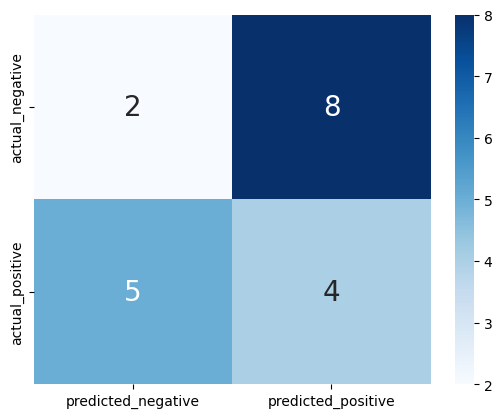

In [210]:
y_predict_RFC = rf_random.predict(X_test)
acc_RFC = accuracy_score(y_test, y_predict_RFC)
print("\nThe Training Score: {} \n".format(rf_random.score(X_train,y_train)*100))
print('The Accuracy is : {}\n\n'.format(acc_RFC) )
cm_RFC = conf_matrix(y_test, y_predict_RFC)
print(classification_report(y_test, y_predict_RFC))

In [215]:
clf = GridSearchCV(RFC, random_grid)

In [216]:
clf.fit(X_train, y_train)

/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_

GridSearchCV(estimator=RandomForestClassifier(n_estimators=8),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       110, 120],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 4],
                         'min_samples_split': [2, 6, 10],
                         'n_estimators': [5, 20, 50, 100]})


The Training Score: 75.70093457943925 

The Accuracy is : 0.3684210526315789


              precision    recall  f1-score   support

           0       0.33      0.20      0.25        10
           1       0.38      0.56      0.45         9

    accuracy                           0.37        19
   macro avg       0.36      0.38      0.35        19
weighted avg       0.36      0.37      0.35        19



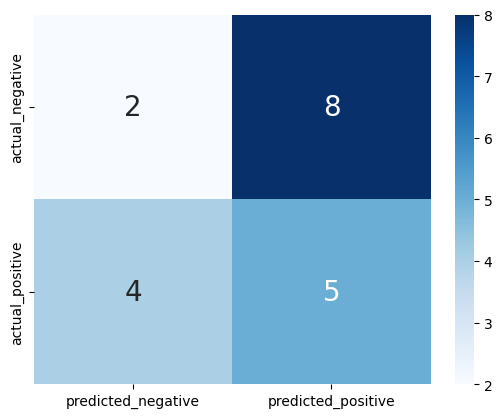

In [219]:
y_predict_RFC = clf.predict(X_test)
acc_RFC = accuracy_score(y_test, y_predict_RFC)
print("\nThe Training Score: {} \n".format(clf.score(X_train,y_train)*100))
print('The Accuracy is : {}\n\n'.format(acc_RFC) )
cm_RFC = conf_matrix(y_test, y_predict_RFC)
print(classification_report(y_test, y_predict_RFC))

In [220]:
grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [221]:
# calculating the accuracy of models with different values of k
mean_acc = np.zeros(20)
for i in range(1,21):
    #Train Model and Predict  
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat= knn.predict(X_test)
    mean_acc[i-1] = accuracy_score(y_test, yhat)

mean_acc

array([0.42105263, 0.47368421, 0.26315789, 0.31578947, 0.31578947,
       0.26315789, 0.42105263, 0.31578947, 0.36842105, 0.36842105,
       0.42105263, 0.36842105, 0.42105263, 0.31578947, 0.42105263,
       0.26315789, 0.31578947, 0.21052632, 0.31578947, 0.26315789])

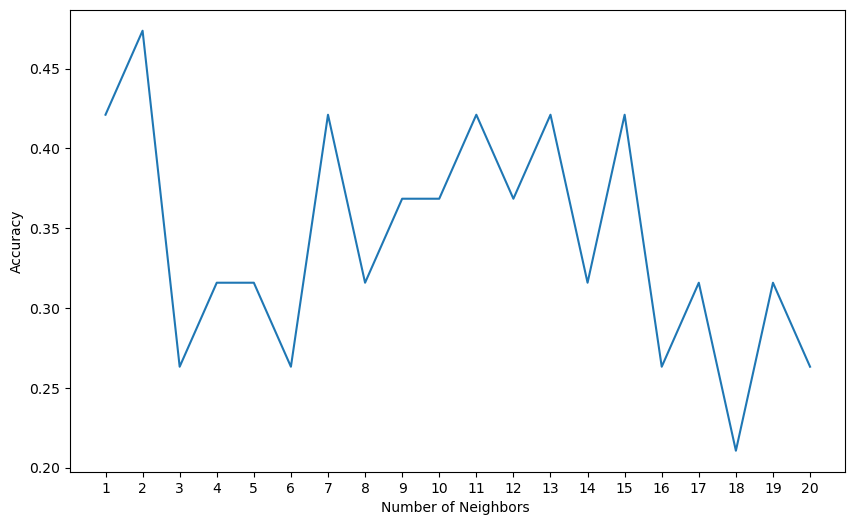

In [222]:
loc = np.arange(1,21,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1,21), mean_acc)
plt.xticks(loc)
plt.xlabel('Number of Neighbors ')
plt.ylabel('Accuracy')
plt.show()

In [223]:
grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [224]:
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)

In [225]:
# fit the model on our train set
g_res = gs.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [226]:
g_res.best_params_

{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}

In [232]:
knn = KNeighborsClassifier(n_neighbors = 2, metric = 'manhattan', weights='uniform')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=2)


The Training Score: 80.37383177570094 

The Accuracy is : 0.47368421052631576


              precision    recall  f1-score   support

           0       0.50      0.60      0.55        10
           1       0.43      0.33      0.38         9

    accuracy                           0.47        19
   macro avg       0.46      0.47      0.46        19
weighted avg       0.47      0.47      0.46        19



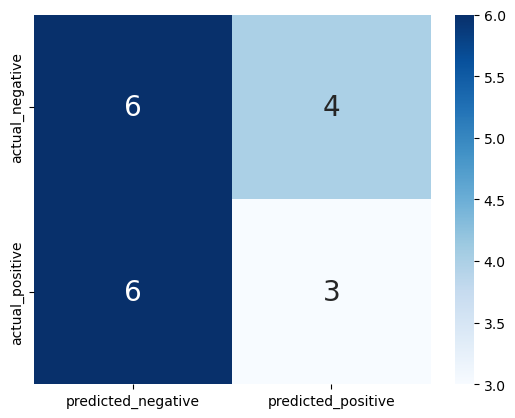

In [234]:
y_predict_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_predict_knn)
print("\nThe Training Score: {} \n".format(knn.score(X_train,y_train)*100))
print('The Accuracy is : {}\n\n'.format(acc_knn) )
cm_knn = conf_matrix(y_test, y_predict_knn)
print(classification_report(y_test, y_predict_knn))

In [241]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

In [242]:
clf = GridSearchCV(LogisticRegression(), param_grid = param_grid, cv = 5, n_jobs=-1)

In [243]:
best_clf = clf.fit(X_train,y_train)

/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mahdiazhari/anaconda3/envs/env_ds/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio paramete

In [239]:
best_clf

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'max_iter': [100, 1000, 2500, 5000],
                          'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                          'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag',
                                     'saga']}],
             verbose=True)

In [240]:
best_clf.best_estimator_

LogisticRegression(C=0.03359818286283781)

In [253]:
SVM_clf = Pipeline([('scale', StandardScaler()),# Scale inputs to 0 mean and 1 variance
                    ('SVM', svm.SVC(kernel='linear', degree=1, gamma='scale'))])

# train the model
SVM_clf=SVM_clf.fit(X_train, y_train)

# preditc the data
y_pred_svm =SVM_clf.predict(X_test)
print('\nAccuracy score to test set: {}\n'.format(round(accuracy_score(y_test, y_pred_svm), 2)))



Accuracy score to test set: 0.38



In [256]:
def resultsReport(actual, predictions) :
    
    # Print F1 Score
    print('F1 Score ', f1_score(actual, predictions))
    
    # Visualize classification report with precision, recall and F1 score
    print(classification_report(actual, predictions))

    # Create Confusion matrix vector
    confMatrix = confusion_matrix(actual, predictions)
    dfConfMatrix = pd.DataFrame(confMatrix, index = [i for i in "01"], 
                                columns = [i for i in "01"])

    # Plot Confusion matrix
    sns.heatmap(dfConfMatrix, annot = True)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

F1 Score  0.5
              precision    recall  f1-score   support

           0       0.22      0.18      0.20        11
           1       0.47      0.53      0.50        15

    accuracy                           0.38        26
   macro avg       0.35      0.36      0.35        26
weighted avg       0.37      0.38      0.37        26



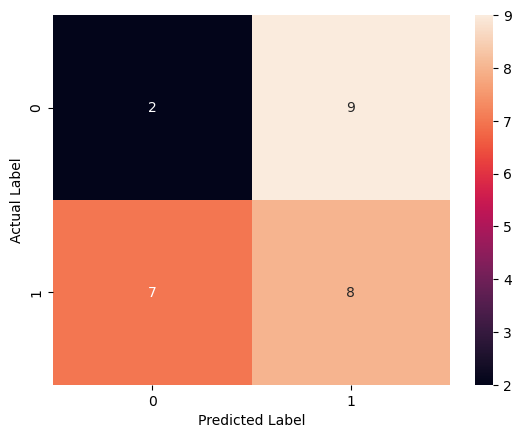

In [257]:
resultsReport(y_test, y_pred_svm)

In [259]:
from sklearn.feature_selection import SelectKBest, chi2

bestfeatures =SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(X_test, y_test)


In [261]:
dfscores=pd.DataFrame(fit.scores_)
dfcolumns =pd.DataFrame(X_test.columns)

In [262]:
featureScores =pd.concat([dfcolumns, dfscores],axis=1)
featureScores.columns= ["Specs", "Score"]

featureScores

,Specs,Score
0,X1,0.021265
1,X2,0.008658
2,X3,1.315696
3,X4,0.000551
4,X5,0.269388
5,X6,0.021265
